## **Import Libraries**

In [1]:
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt
import pylab
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset
import PIL

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## **Preparing Dataset for task 2**

**Data Preprocessing:**

In [3]:
# specify paths 
label_file = 'CelebA\Anno\list_attr_celeba.txt'
img_dir = 'CelebA\Img\img_align_celeba\img_align_celeba'
output_dir = 'task3_data'

os.makedirs(output_dir, exist_ok=True)

# load labels file
data= pd.read_csv(label_file, sep='\s+',skiprows=[0], header=0) #on_bad_lines='skip'
data = data[['Male','Black_Hair','Wearing_Earrings','Eyeglasses','Straight_Hair','Smiling','Wearing_Necktie']]
#data = data.reset_index()
label_map = {1 : 1, -1 : 0}
data = data.applymap(label_map.get)

# choosing combinmation such that label for each category are almost equal
new_data = data[ (data['Wearing_Earrings'] == 1) |(data['Eyeglasses'] == 1) |(data['Wearing_Necktie'] == 1)]
new_data['image']=new_data.index

# saving data to csv file
new_data.to_csv(os.path.join(output_dir,'task3.csv'),index=False)

C:\Windows\TEMP/ipykernel_21412/3358446840.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['image']=new_data.index


**Data Loading:**

In [3]:
class Custom_Dataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None): 
        # Run once
        self.img_labels = pd.read_csv(csv_file)
        self.transform = transform
        self.img_dir = img_dir
    
    def __len__(self):
        # return the number of samples in dataset
        return len(self.img_labels)

    def __getitem__(self, idx):
        # loads and returns a sample from the dataset at the given index
        img_path = os.path.join(self.img_dir ,self.img_labels.iloc[idx, -1])
        image = PIL.Image.open(img_path)
        label = torch.tensor(self.img_labels.iloc[idx][0:-1])
    
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [4]:
def load_dataset(csv_file, img_dir,train_size, validation_size, test_size, batch_size):

    transform = transforms.Compose([#transforms.Grayscale(), 
                                     transforms.ToTensor(),
                                     #transforms.Resize((28,28)), 
                                     #transforms.Normalize(0,0.5)
                                     ])
    # read dataset
    dataset = Custom_Dataset(csv_file=csv_file, img_dir=img_dir, transform = transform)

    # specify sizes
    train_set_size = int(len(dataset) * train_size)
    test_set_size = int(len(dataset) * test_size)
    val_set_size = len(dataset) - train_set_size - test_set_size

    # split data
    train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_set_size,val_set_size,test_set_size])

    # create dataloader for each data (test,train,val)
    train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    
    #return
    return train_data_loader, val_data_loader, test_data_loader

In [5]:
img_dir = 'CelebA\Img\img_align_celeba\img_align_celeba'
csv_file = 'task3_data/task3.csv'
train_data_loader, val_data_loader, test_data_loader = load_dataset(csv_file,img_dir,0.7,0.15,0.15, 16)

## **Creating Model**

In [6]:
from torch import nn
import torch.nn.functional as F
from torch import optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3*218*178, 1000)
        self.fc2 = nn.Linear(1000, 800)
        self.fc3 = nn.Linear(800, 400)
        self.fc4 = nn.Linear(400, 200)
        self.fc5 = nn.Linear(200, 7)


    def forward(self, x):
        x = torch.flatten(x, 1)  
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# model
net = Net().to(device)

## Training Model

In [7]:
def train(epochs, train_data_loader, val_data_loader, loss_func, optimizer, learning_rate):
    train_step = len(train_data_loader)
    val_step = len(val_data_loader)
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    for epoch in range(epochs): # iterate over epochs
        t_loss = 0
        t_acc = 0 
        for i, data in enumerate(train_data_loader): # iterate over batches
            
          # get image and labels data is in tuple form (inputs, label)
            image, labels = data
            image = image.to(device)
            labels = labels.to(device).float()
         
            # Zero-out gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(image)
            pred = torch.tensor([[1 if i > 0.5 else 0 for i in y ] for y in outputs])
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            t_loss += loss.item()
            t_acc += torch.sum((pred == labels).all(axis = 1))/len(labels)

            if (i+1) % 10 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch+1, epochs, i+1, train_step, loss.item()))
    
        v_loss = 0
        v_acc = 0
        for i, data in enumerate(val_data_loader): # iterate over batches
            # get image and labels data is in tuple form (inputs, label)
            image, labels = data
            image = image.to(device)
            labels = labels.to(device).float()
            outputs = net(image)
            #pred = np.squeeze(outputs)
            pred = torch.tensor([[1 if i > 0.5 else 0 for i in y ] for y in outputs])
            loss = loss_func(outputs, labels)
            v_loss += loss.item()
            v_acc += torch.sum((pred == labels).all(axis = 1))/len(labels)
            v_acc += torch.sum(pred == labels)/len(labels)
     
        train_loss.append(t_loss/train_step)
        train_acc.append(t_acc/train_step)
        val_loss.append(v_loss/val_step)
        val_acc.append(v_acc/val_step)
        print ('Epoch [{}/{}], train_loss: {:.4f}, val_loss: {:.4f}' .format(epoch+1, epochs, train_loss[-1], val_loss[-1]))
    
    return train_loss, train_acc, val_loss, val_acc

In [25]:
# loss
criterion = nn.MultiLabelSoftMarginLoss()

#optimizer
learning_rate = 0.0001
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

#training
train_loss, train_acc, val_loss, val_acc= train(10, train_data_loader,  val_data_loader,criterion, optimizer, learning_rate)

Epoch [1/10], Step [10/2737], Loss: 0.6347
Epoch [1/10], Step [20/2737], Loss: 0.6412
Epoch [1/10], Step [30/2737], Loss: 0.5690
Epoch [1/10], Step [40/2737], Loss: 0.5582
Epoch [1/10], Step [50/2737], Loss: 0.8029
Epoch [1/10], Step [60/2737], Loss: 0.5839
Epoch [1/10], Step [70/2737], Loss: 0.5659
Epoch [1/10], Step [80/2737], Loss: 0.5461
Epoch [1/10], Step [90/2737], Loss: 0.6123
Epoch [1/10], Step [100/2737], Loss: 0.5203
Epoch [1/10], Step [110/2737], Loss: 0.5736
Epoch [1/10], Step [120/2737], Loss: 0.4318
Epoch [1/10], Step [130/2737], Loss: 0.4522
Epoch [1/10], Step [140/2737], Loss: 0.4945
Epoch [1/10], Step [150/2737], Loss: 0.4027
Epoch [1/10], Step [160/2737], Loss: 0.4849
Epoch [1/10], Step [170/2737], Loss: 0.4991
Epoch [1/10], Step [180/2737], Loss: 0.4220
Epoch [1/10], Step [190/2737], Loss: 0.3319
Epoch [1/10], Step [200/2737], Loss: 0.5126
Epoch [1/10], Step [210/2737], Loss: 0.3898
Epoch [1/10], Step [220/2737], Loss: 0.4510
Epoch [1/10], Step [230/2737], Loss: 0.42

Epoch [1/10], Step [1860/2737], Loss: 0.6161
Epoch [1/10], Step [1870/2737], Loss: 0.4435
Epoch [1/10], Step [1880/2737], Loss: 0.3535
Epoch [1/10], Step [1890/2737], Loss: 0.2830
Epoch [1/10], Step [1900/2737], Loss: 0.3222
Epoch [1/10], Step [1910/2737], Loss: 0.2536
Epoch [1/10], Step [1920/2737], Loss: 0.3628
Epoch [1/10], Step [1930/2737], Loss: 0.2671
Epoch [1/10], Step [1940/2737], Loss: 0.4350
Epoch [1/10], Step [1950/2737], Loss: 0.2387
Epoch [1/10], Step [1960/2737], Loss: 0.3143
Epoch [1/10], Step [1970/2737], Loss: 0.2704
Epoch [1/10], Step [1980/2737], Loss: 0.3894
Epoch [1/10], Step [1990/2737], Loss: 0.3281
Epoch [1/10], Step [2000/2737], Loss: 0.3664
Epoch [1/10], Step [2010/2737], Loss: 0.1877
Epoch [1/10], Step [2020/2737], Loss: 0.2870
Epoch [1/10], Step [2030/2737], Loss: 0.4393
Epoch [1/10], Step [2040/2737], Loss: 0.3046
Epoch [1/10], Step [2050/2737], Loss: 0.2980
Epoch [1/10], Step [2060/2737], Loss: 0.4119
Epoch [1/10], Step [2070/2737], Loss: 0.3236
Epoch [1/1

Epoch [2/10], Step [970/2737], Loss: 0.2124
Epoch [2/10], Step [980/2737], Loss: 0.2613
Epoch [2/10], Step [990/2737], Loss: 0.3166
Epoch [2/10], Step [1000/2737], Loss: 0.3213
Epoch [2/10], Step [1010/2737], Loss: 0.2558
Epoch [2/10], Step [1020/2737], Loss: 0.2922
Epoch [2/10], Step [1030/2737], Loss: 0.3712
Epoch [2/10], Step [1040/2737], Loss: 0.2259
Epoch [2/10], Step [1050/2737], Loss: 0.4103
Epoch [2/10], Step [1060/2737], Loss: 0.3622
Epoch [2/10], Step [1070/2737], Loss: 0.3085
Epoch [2/10], Step [1080/2737], Loss: 0.2129
Epoch [2/10], Step [1090/2737], Loss: 0.3451
Epoch [2/10], Step [1100/2737], Loss: 0.3445
Epoch [2/10], Step [1110/2737], Loss: 0.2603
Epoch [2/10], Step [1120/2737], Loss: 0.2954
Epoch [2/10], Step [1130/2737], Loss: 0.3169
Epoch [2/10], Step [1140/2737], Loss: 0.2361
Epoch [2/10], Step [1150/2737], Loss: 0.3008
Epoch [2/10], Step [1160/2737], Loss: 0.2211
Epoch [2/10], Step [1170/2737], Loss: 0.3245
Epoch [2/10], Step [1180/2737], Loss: 0.2422
Epoch [2/10],

Epoch [3/10], Step [60/2737], Loss: 0.2720
Epoch [3/10], Step [70/2737], Loss: 0.3092
Epoch [3/10], Step [80/2737], Loss: 0.2218
Epoch [3/10], Step [90/2737], Loss: 0.2028
Epoch [3/10], Step [100/2737], Loss: 0.1771
Epoch [3/10], Step [110/2737], Loss: 0.3466
Epoch [3/10], Step [120/2737], Loss: 0.3289
Epoch [3/10], Step [130/2737], Loss: 0.2625
Epoch [3/10], Step [140/2737], Loss: 0.3588
Epoch [3/10], Step [150/2737], Loss: 0.1895
Epoch [3/10], Step [160/2737], Loss: 0.1968
Epoch [3/10], Step [170/2737], Loss: 0.3151
Epoch [3/10], Step [180/2737], Loss: 0.2710
Epoch [3/10], Step [190/2737], Loss: 0.2775
Epoch [3/10], Step [200/2737], Loss: 0.2901
Epoch [3/10], Step [210/2737], Loss: 0.3863
Epoch [3/10], Step [220/2737], Loss: 0.2597
Epoch [3/10], Step [230/2737], Loss: 0.3538
Epoch [3/10], Step [240/2737], Loss: 0.2628
Epoch [3/10], Step [250/2737], Loss: 0.1670
Epoch [3/10], Step [260/2737], Loss: 0.2480
Epoch [3/10], Step [270/2737], Loss: 0.3016
Epoch [3/10], Step [280/2737], Loss:

Epoch [3/10], Step [1910/2737], Loss: 0.2496
Epoch [3/10], Step [1920/2737], Loss: 0.3327
Epoch [3/10], Step [1930/2737], Loss: 0.2223
Epoch [3/10], Step [1940/2737], Loss: 0.1943
Epoch [3/10], Step [1950/2737], Loss: 0.2297
Epoch [3/10], Step [1960/2737], Loss: 0.2605
Epoch [3/10], Step [1970/2737], Loss: 0.2887
Epoch [3/10], Step [1980/2737], Loss: 0.1267
Epoch [3/10], Step [1990/2737], Loss: 0.2843
Epoch [3/10], Step [2000/2737], Loss: 0.2725
Epoch [3/10], Step [2010/2737], Loss: 0.2230
Epoch [3/10], Step [2020/2737], Loss: 0.3268
Epoch [3/10], Step [2030/2737], Loss: 0.2588
Epoch [3/10], Step [2040/2737], Loss: 0.2651
Epoch [3/10], Step [2050/2737], Loss: 0.2929
Epoch [3/10], Step [2060/2737], Loss: 0.2330
Epoch [3/10], Step [2070/2737], Loss: 0.1868
Epoch [3/10], Step [2080/2737], Loss: 0.1871
Epoch [3/10], Step [2090/2737], Loss: 0.2948
Epoch [3/10], Step [2100/2737], Loss: 0.2231
Epoch [3/10], Step [2110/2737], Loss: 0.3068
Epoch [3/10], Step [2120/2737], Loss: 0.2099
Epoch [3/1

Epoch [4/10], Step [1020/2737], Loss: 0.2035
Epoch [4/10], Step [1030/2737], Loss: 0.2174
Epoch [4/10], Step [1040/2737], Loss: 0.2355
Epoch [4/10], Step [1050/2737], Loss: 0.2862
Epoch [4/10], Step [1060/2737], Loss: 0.2165
Epoch [4/10], Step [1070/2737], Loss: 0.2105
Epoch [4/10], Step [1080/2737], Loss: 0.1819
Epoch [4/10], Step [1090/2737], Loss: 0.1999
Epoch [4/10], Step [1100/2737], Loss: 0.2083
Epoch [4/10], Step [1110/2737], Loss: 0.2109
Epoch [4/10], Step [1120/2737], Loss: 0.2611
Epoch [4/10], Step [1130/2737], Loss: 0.3400
Epoch [4/10], Step [1140/2737], Loss: 0.1697
Epoch [4/10], Step [1150/2737], Loss: 0.2786
Epoch [4/10], Step [1160/2737], Loss: 0.2589
Epoch [4/10], Step [1170/2737], Loss: 0.2785
Epoch [4/10], Step [1180/2737], Loss: 0.2205
Epoch [4/10], Step [1190/2737], Loss: 0.2235
Epoch [4/10], Step [1200/2737], Loss: 0.3073
Epoch [4/10], Step [1210/2737], Loss: 0.2322
Epoch [4/10], Step [1220/2737], Loss: 0.2220
Epoch [4/10], Step [1230/2737], Loss: 0.2056
Epoch [4/1

Epoch [5/10], Step [110/2737], Loss: 0.2059
Epoch [5/10], Step [120/2737], Loss: 0.2566
Epoch [5/10], Step [130/2737], Loss: 0.3254
Epoch [5/10], Step [140/2737], Loss: 0.2996
Epoch [5/10], Step [150/2737], Loss: 0.1725
Epoch [5/10], Step [160/2737], Loss: 0.3611
Epoch [5/10], Step [170/2737], Loss: 0.2006
Epoch [5/10], Step [180/2737], Loss: 0.1974
Epoch [5/10], Step [190/2737], Loss: 0.2512
Epoch [5/10], Step [200/2737], Loss: 0.2975
Epoch [5/10], Step [210/2737], Loss: 0.3245
Epoch [5/10], Step [220/2737], Loss: 0.1999
Epoch [5/10], Step [230/2737], Loss: 0.1557
Epoch [5/10], Step [240/2737], Loss: 0.2195
Epoch [5/10], Step [250/2737], Loss: 0.3012
Epoch [5/10], Step [260/2737], Loss: 0.2492
Epoch [5/10], Step [270/2737], Loss: 0.2987
Epoch [5/10], Step [280/2737], Loss: 0.2235
Epoch [5/10], Step [290/2737], Loss: 0.1898
Epoch [5/10], Step [300/2737], Loss: 0.3154
Epoch [5/10], Step [310/2737], Loss: 0.1528
Epoch [5/10], Step [320/2737], Loss: 0.3160
Epoch [5/10], Step [330/2737], L

Epoch [5/10], Step [1960/2737], Loss: 0.2734
Epoch [5/10], Step [1970/2737], Loss: 0.1680
Epoch [5/10], Step [1980/2737], Loss: 0.2803
Epoch [5/10], Step [1990/2737], Loss: 0.1871
Epoch [5/10], Step [2000/2737], Loss: 0.2070
Epoch [5/10], Step [2010/2737], Loss: 0.3230
Epoch [5/10], Step [2020/2737], Loss: 0.1803
Epoch [5/10], Step [2030/2737], Loss: 0.1942
Epoch [5/10], Step [2040/2737], Loss: 0.4921
Epoch [5/10], Step [2050/2737], Loss: 0.2501
Epoch [5/10], Step [2060/2737], Loss: 0.2593
Epoch [5/10], Step [2070/2737], Loss: 0.2574
Epoch [5/10], Step [2080/2737], Loss: 0.3038
Epoch [5/10], Step [2090/2737], Loss: 0.2516
Epoch [5/10], Step [2100/2737], Loss: 0.1678
Epoch [5/10], Step [2110/2737], Loss: 0.2534
Epoch [5/10], Step [2120/2737], Loss: 0.1811
Epoch [5/10], Step [2130/2737], Loss: 0.1898
Epoch [5/10], Step [2140/2737], Loss: 0.2184
Epoch [5/10], Step [2150/2737], Loss: 0.2274
Epoch [5/10], Step [2160/2737], Loss: 0.3393
Epoch [5/10], Step [2170/2737], Loss: 0.2346
Epoch [5/1

Epoch [6/10], Step [1070/2737], Loss: 0.3962
Epoch [6/10], Step [1080/2737], Loss: 0.2117
Epoch [6/10], Step [1090/2737], Loss: 0.2299
Epoch [6/10], Step [1100/2737], Loss: 0.1609
Epoch [6/10], Step [1110/2737], Loss: 0.2819
Epoch [6/10], Step [1120/2737], Loss: 0.2479
Epoch [6/10], Step [1130/2737], Loss: 0.1879
Epoch [6/10], Step [1140/2737], Loss: 0.3115
Epoch [6/10], Step [1150/2737], Loss: 0.4137
Epoch [6/10], Step [1160/2737], Loss: 0.2154
Epoch [6/10], Step [1170/2737], Loss: 0.1494
Epoch [6/10], Step [1180/2737], Loss: 0.2525
Epoch [6/10], Step [1190/2737], Loss: 0.1396
Epoch [6/10], Step [1200/2737], Loss: 0.2226
Epoch [6/10], Step [1210/2737], Loss: 0.2488
Epoch [6/10], Step [1220/2737], Loss: 0.2417
Epoch [6/10], Step [1230/2737], Loss: 0.2195
Epoch [6/10], Step [1240/2737], Loss: 0.1813
Epoch [6/10], Step [1250/2737], Loss: 0.2161
Epoch [6/10], Step [1260/2737], Loss: 0.2236
Epoch [6/10], Step [1270/2737], Loss: 0.2535
Epoch [6/10], Step [1280/2737], Loss: 0.1698
Epoch [6/1

Epoch [7/10], Step [160/2737], Loss: 0.2528
Epoch [7/10], Step [170/2737], Loss: 0.2148
Epoch [7/10], Step [180/2737], Loss: 0.1958
Epoch [7/10], Step [190/2737], Loss: 0.2290
Epoch [7/10], Step [200/2737], Loss: 0.2095
Epoch [7/10], Step [210/2737], Loss: 0.1101
Epoch [7/10], Step [220/2737], Loss: 0.1680
Epoch [7/10], Step [230/2737], Loss: 0.2212
Epoch [7/10], Step [240/2737], Loss: 0.2047
Epoch [7/10], Step [250/2737], Loss: 0.2129
Epoch [7/10], Step [260/2737], Loss: 0.2778
Epoch [7/10], Step [270/2737], Loss: 0.1962
Epoch [7/10], Step [280/2737], Loss: 0.1449
Epoch [7/10], Step [290/2737], Loss: 0.2381
Epoch [7/10], Step [300/2737], Loss: 0.3047
Epoch [7/10], Step [310/2737], Loss: 0.1480
Epoch [7/10], Step [320/2737], Loss: 0.2692
Epoch [7/10], Step [330/2737], Loss: 0.1334
Epoch [7/10], Step [340/2737], Loss: 0.2245
Epoch [7/10], Step [350/2737], Loss: 0.1773
Epoch [7/10], Step [360/2737], Loss: 0.1841
Epoch [7/10], Step [370/2737], Loss: 0.2326
Epoch [7/10], Step [380/2737], L

Epoch [7/10], Step [2000/2737], Loss: 0.2284
Epoch [7/10], Step [2010/2737], Loss: 0.3736
Epoch [7/10], Step [2020/2737], Loss: 0.1813
Epoch [7/10], Step [2030/2737], Loss: 0.2575
Epoch [7/10], Step [2040/2737], Loss: 0.3171
Epoch [7/10], Step [2050/2737], Loss: 0.2876
Epoch [7/10], Step [2060/2737], Loss: 0.4572
Epoch [7/10], Step [2070/2737], Loss: 0.1575
Epoch [7/10], Step [2080/2737], Loss: 0.2958
Epoch [7/10], Step [2090/2737], Loss: 0.2242
Epoch [7/10], Step [2100/2737], Loss: 0.2717
Epoch [7/10], Step [2110/2737], Loss: 0.2569
Epoch [7/10], Step [2120/2737], Loss: 0.2323
Epoch [7/10], Step [2130/2737], Loss: 0.1852
Epoch [7/10], Step [2140/2737], Loss: 0.2193
Epoch [7/10], Step [2150/2737], Loss: 0.2209
Epoch [7/10], Step [2160/2737], Loss: 0.2003
Epoch [7/10], Step [2170/2737], Loss: 0.1767
Epoch [7/10], Step [2180/2737], Loss: 0.1452
Epoch [7/10], Step [2190/2737], Loss: 0.2118
Epoch [7/10], Step [2200/2737], Loss: 0.2013
Epoch [7/10], Step [2210/2737], Loss: 0.2284
Epoch [7/1

Epoch [8/10], Step [1110/2737], Loss: 0.2067
Epoch [8/10], Step [1120/2737], Loss: 0.2015
Epoch [8/10], Step [1130/2737], Loss: 0.2624
Epoch [8/10], Step [1140/2737], Loss: 0.1579
Epoch [8/10], Step [1150/2737], Loss: 0.3011
Epoch [8/10], Step [1160/2737], Loss: 0.2075
Epoch [8/10], Step [1170/2737], Loss: 0.1660
Epoch [8/10], Step [1180/2737], Loss: 0.1522
Epoch [8/10], Step [1190/2737], Loss: 0.1484
Epoch [8/10], Step [1200/2737], Loss: 0.1340
Epoch [8/10], Step [1210/2737], Loss: 0.2764
Epoch [8/10], Step [1220/2737], Loss: 0.2784
Epoch [8/10], Step [1230/2737], Loss: 0.2371
Epoch [8/10], Step [1240/2737], Loss: 0.3446
Epoch [8/10], Step [1250/2737], Loss: 0.1732
Epoch [8/10], Step [1260/2737], Loss: 0.1937
Epoch [8/10], Step [1270/2737], Loss: 0.2802
Epoch [8/10], Step [1280/2737], Loss: 0.2069
Epoch [8/10], Step [1290/2737], Loss: 0.1952
Epoch [8/10], Step [1300/2737], Loss: 0.3216
Epoch [8/10], Step [1310/2737], Loss: 0.2556
Epoch [8/10], Step [1320/2737], Loss: 0.3352
Epoch [8/1

Epoch [9/10], Step [200/2737], Loss: 0.2798
Epoch [9/10], Step [210/2737], Loss: 0.2530
Epoch [9/10], Step [220/2737], Loss: 0.2037
Epoch [9/10], Step [230/2737], Loss: 0.2435
Epoch [9/10], Step [240/2737], Loss: 0.2138
Epoch [9/10], Step [250/2737], Loss: 0.2967
Epoch [9/10], Step [260/2737], Loss: 0.1176
Epoch [9/10], Step [270/2737], Loss: 0.3168
Epoch [9/10], Step [280/2737], Loss: 0.1814
Epoch [9/10], Step [290/2737], Loss: 0.1772
Epoch [9/10], Step [300/2737], Loss: 0.2242
Epoch [9/10], Step [310/2737], Loss: 0.1691
Epoch [9/10], Step [320/2737], Loss: 0.1888
Epoch [9/10], Step [330/2737], Loss: 0.2201
Epoch [9/10], Step [340/2737], Loss: 0.2595
Epoch [9/10], Step [350/2737], Loss: 0.1666
Epoch [9/10], Step [360/2737], Loss: 0.1788
Epoch [9/10], Step [370/2737], Loss: 0.2144
Epoch [9/10], Step [380/2737], Loss: 0.3076
Epoch [9/10], Step [390/2737], Loss: 0.2361
Epoch [9/10], Step [400/2737], Loss: 0.2134
Epoch [9/10], Step [410/2737], Loss: 0.2044
Epoch [9/10], Step [420/2737], L

Epoch [9/10], Step [2040/2737], Loss: 0.2703
Epoch [9/10], Step [2050/2737], Loss: 0.2079
Epoch [9/10], Step [2060/2737], Loss: 0.1886
Epoch [9/10], Step [2070/2737], Loss: 0.1740
Epoch [9/10], Step [2080/2737], Loss: 0.2153
Epoch [9/10], Step [2090/2737], Loss: 0.1810
Epoch [9/10], Step [2100/2737], Loss: 0.3231
Epoch [9/10], Step [2110/2737], Loss: 0.2711
Epoch [9/10], Step [2120/2737], Loss: 0.1463
Epoch [9/10], Step [2130/2737], Loss: 0.1904
Epoch [9/10], Step [2140/2737], Loss: 0.1823
Epoch [9/10], Step [2150/2737], Loss: 0.2037
Epoch [9/10], Step [2160/2737], Loss: 0.3261
Epoch [9/10], Step [2170/2737], Loss: 0.2709
Epoch [9/10], Step [2180/2737], Loss: 0.2121
Epoch [9/10], Step [2190/2737], Loss: 0.2090
Epoch [9/10], Step [2200/2737], Loss: 0.1626
Epoch [9/10], Step [2210/2737], Loss: 0.1217
Epoch [9/10], Step [2220/2737], Loss: 0.2365
Epoch [9/10], Step [2230/2737], Loss: 0.2369
Epoch [9/10], Step [2240/2737], Loss: 0.2636
Epoch [9/10], Step [2250/2737], Loss: 0.1673
Epoch [9/1

Epoch [10/10], Step [1120/2737], Loss: 0.2197
Epoch [10/10], Step [1130/2737], Loss: 0.3016
Epoch [10/10], Step [1140/2737], Loss: 0.1099
Epoch [10/10], Step [1150/2737], Loss: 0.2740
Epoch [10/10], Step [1160/2737], Loss: 0.1880
Epoch [10/10], Step [1170/2737], Loss: 0.2404
Epoch [10/10], Step [1180/2737], Loss: 0.1721
Epoch [10/10], Step [1190/2737], Loss: 0.1212
Epoch [10/10], Step [1200/2737], Loss: 0.1743
Epoch [10/10], Step [1210/2737], Loss: 0.2954
Epoch [10/10], Step [1220/2737], Loss: 0.2257
Epoch [10/10], Step [1230/2737], Loss: 0.2344
Epoch [10/10], Step [1240/2737], Loss: 0.1430
Epoch [10/10], Step [1250/2737], Loss: 0.2773
Epoch [10/10], Step [1260/2737], Loss: 0.2767
Epoch [10/10], Step [1270/2737], Loss: 0.3063
Epoch [10/10], Step [1280/2737], Loss: 0.1755
Epoch [10/10], Step [1290/2737], Loss: 0.2841
Epoch [10/10], Step [1300/2737], Loss: 0.2305
Epoch [10/10], Step [1310/2737], Loss: 0.2226
Epoch [10/10], Step [1320/2737], Loss: 0.2135
Epoch [10/10], Step [1330/2737], L

## **Save Model**

In [26]:
path = 'saved_models/task3/task3.pt'
torch.save(net.state_dict(), path)

np.save('saved_models/task3/train_loss', train_loss)
np.save('saved_models/task3/val_loss', val_loss)
np.save('saved_models/task3/train_acc', train_acc)
np.save('saved_models/task3/val_acc', val_acc)

## **Test Model**

In [27]:
dataiter = iter(test_data_loader)
img, test_labels = dataiter.next()
print(test_labels)

tensor([[0, 0, 1, 0, 0, 1, 0],
        [1, 1, 0, 1, 0, 1, 0],
        [0, 1, 1, 0, 0, 0, 0],
        [1, 1, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 1, 1],
        [0, 0, 1, 0, 0, 1, 0],
        [0, 1, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 0, 1, 0]])


In [28]:
# load model
net.load_state_dict(torch.load(path))
test_out = net(img.to(device))
test_out.shape
pred = torch.tensor([[1 if i > 0.5 else 0 for i in y ] for y in test_out])
pred

tensor([[0, 0, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 0, 1, 0],
        [0, 1, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0, 1, 0],
        [0, 1, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 0, 1, 0]])

In [9]:
# load model
path = 'saved_models/task3/epoch10,lr0.001/task3.pt'
net = Net().to(device)
net.load_state_dict(torch.load(path))

test_steps = len(test_data_loader)
t_acc=0
for i, data in enumerate(test_data_loader): # iterate over batches
    # get image and labels data is in tuple form (inputs, label)
    image, labels = data
    image = image.to(device)
    labels = labels.to(device).float()
    outputs = net(image)
    pred = torch.tensor([[1 if i > 0.5 else 0 for i in y ] for y in outputs])
    t_acc += torch.sum((pred == labels).all(axis = 1))/len(labels)

print('Test Accuracy: {:.4f}'.format(t_acc/test_steps))

Test Accuracy: 0.5329


## **Visualize result**

Text(0.5, 1.0, 'training and validation loss')

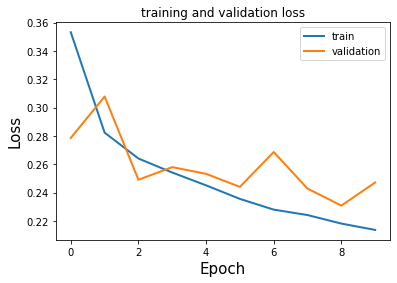

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

train_loss = np.load('saved_models/task3/epoch10,lr0.001/train_loss.npy')
val_loss = np.load('saved_models/task3/epoch10,lr0.001/val_loss.npy')
plt.plot(train_loss, linewidth=2, label='train')
plt.plot(val_loss, linewidth=2, label='validation')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()
plt.title('training and validation loss')

val accuracy: 0.53932226
train accuracy: 0.53932226


Text(0.5, 1.0, 'training and validation Accuracy')

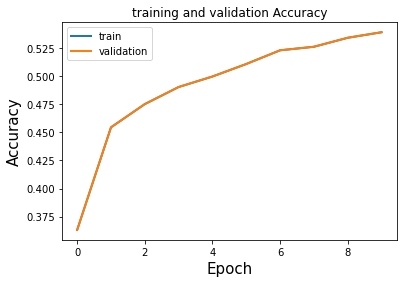

In [2]:
val_acc = np.load('saved_models/task3/epoch10,lr0.001/val_acc.npy')
train_acc = np.load('saved_models/task3/epoch10,lr0.001/train_acc.npy')
print('val accuracy:', val_acc[-1])
print('train accuracy:', train_acc[-1])
plt.plot(train_acc, linewidth=2, label='train')
plt.plot(val_acc, linewidth=2, label='validation')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend()
plt.title('training and validation Accuracy')